## Описание датасета:

The data set consists of paper reviews sent to an international conference mostly in Spanish (some are in English). It has a total of N = 405 instances evaluated with a 5-point scale ('-2': very negative, '-1': negative, '0': neutral, '1': positive, '2': very positive), expressing the reviewer's opinion about the paper and the orientation perceived by a reader who does not know the reviewer's evaluation (more details in the attributes' section). The distribution of the original scores is more uniform in comparison to the revised scores. This difference is assumed to come from a discrepancy between the way the paper is evaluated and the way the review is written by the original reviewer. 

The data set is stored in JSON format, the structure is as follows: 
Paper: { 
papers have an associated timespan and a paper ID, each paper contains some reviews. The reviews have their own ID, the review text, the remarks (which can be empty), the language of the review, its orientation and evaluation. 

Some relevant statistics (excluding reviews in English and empty reviews): 
- Number of words: 
Min: 3 Max: 530 Avg: 88.64 Stdev: 69.76 
- Number of sentences: 
Min: 1 Max: 47 Avg: 8.91 Stdev: 7.54

Attribute Information:

1. Timespan (datetime): A date associated with the year of conference, which in turn corresponds with the time the review was written. The data set includes four years of reviews worth of conferences. 
2. Paper ID (integer): This number identifies each individual paper from a given conference. The data set has 172 different papers. 
3. Preliminary decision (label): The preliminary decision of acceptance or rejection of a paper taken by the conference committee. 
4. Review ID (integer: A serial number identifier for each review as a correlative with respect to each individual paper. (e.g. the second review of some paper would correspond to the number $2$). The data set has a total of 405 reviews. Most papers have 2 reviews each. 
5. Text (text): Comments and detailed review of the paper. This is read by the authors and the editing commission of the conference. The editors determine if the paper should be published or not depending on the reviews. There are $6$ instances of empty reviews. 
6. Remarks (text): Additional comments that can be read only by the editing commission of the conference. This is used in conjunction with the previous attribute to determine if the paper should be published. This is an optional attribute. Whenever it is possible it is concatenated at the end of the main body of the review. Some reviews do not have remarks, this is indicated with an empty string ''. 
7. Language (text): Language corresponding to the review (it may be English or Spanish). In this case the majority of the reviews are in Spanish, with only $17$ instances of English reviews. 
8. Orientation (integer from -2 to 2): Review classification defined by the authors of this study, according to the 5-point scale previously described, obtained through the authors' systematic judgement of each review. This attribute represents the subjective perception of each review (i.e. how negative or positive the review is perceived when someone reads it). 
9. Evaluation (integer from -2 to 2): Review classification as defined by the reviewer, according to the 5-point scale previously described. This attribute represents the real evaluation given to the paper, as determined by the reviewers. 
10. Confidence (integer from 1 to 5): Value describing the confidence of the reviewer, a higher value denotes more confidence, while a lower value indicates less confidence.

Источник: http://archive.ics.uci.edu/ml/datasets/Paper+Reviews

## Задача
Предсказать evaluation (от -2 до 2) по тексту ревью.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

SpanishStemmer = SnowballStemmer('spanish')
EnglishLemmatizer = WordNetLemmatizer()
stopwords = {'en': set(stopwords.words('english')), 'es': set(stopwords.words('spanish'))}
Count = CountVectorizer()
Tfidf = TfidfVectorizer()
clf_count = OneVsOneClassifier(LogisticRegressionCV())
clf_tfidf = OneVsOneClassifier(LogisticRegressionCV())

data = pd.read_csv('reviews.csv')
data.head()

,id,preliminary_decision,review__confidence,review__evaluation,review__id,review__lan,review__orientation,review__remarks,review__text,review__timespan
0,1.0,accept,4.0,1.0,1.0,es,0.0,NaN,- El artículo aborda un problema contingente y...,2010-07-05
1,NaN,NaN,4.0,1.0,2.0,es,1.0,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05
2,NaN,NaN,5.0,1.0,3.0,es,1.0,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05
3,2.0,accept,4.0,2.0,1.0,es,1.0,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05
4,NaN,NaN,4.0,2.0,2.0,es,0.0,NaN,NaN,2010-07-05


In [2]:
data = data.dropna(subset=['review__text', 'review__evaluation']) # чистим данные от строчек без оценки или ревью
data.shape

(399, 10)

In [3]:
y = np.array(data['review__evaluation']) # выделяем целевой столбец

## Препроцессинг текстов

In [4]:
def preprocess_text(text, lan):
    text = list(filter(lambda x: len(x) > 0, re.split('\W+', text.lower()))) # разбиваем текст на слова
    new_text = []
    for word in text:
        if lan == 'es':
            word = SpanishStemmer.stem(word)
            # приводим слова к основе для большей точности (приличного лемматизатора для испанского я не нашла :( )
        elif lan == 'en':
            word = EnglishLemmatizer.lemmatize(word) # лемматизируем слова
        if word not in stopwords[lan]: # убираем стоп-слова
            new_text.append(word)
    return ' '.join(new_text)


X = []

for row in data.iterrows(): # вытаскиваем тексты из датасета и препроцессим их
    text = row[1]['review__text']
    if row[1].notna()['review__remarks']:
        text += row[1]['review__remarks']
    lan = row[1]['review__lan']
    X.append(preprocess_text(text, lan))

In [5]:
X[:5]

['articul abord problem contingent relev inclu tant diagnost nacional uso buen practic com solucion buen practic concret lenguaj adecu articul sient com concaten tres articul diferent 1 result encuest 2 buen practic segur 3 incorpor buen practic orden seccion ser mejor si reflej orden version revis 2 1 3 articul tien valid ningun tip siqu evalu expert',
 'articul present recomend practic par desarroll softwar segur describ mejor practic recomend par desarroll softwar proactiv ataqu realiz analisis cost practic desarroll softwar tod bas revision practic propuest bibliograf contr dat obten encuest empres final recomiend gui ser ideal aplic gui propuest empres involucr encuest sirv par origin mod pod evalu efect form independient',
 'tem interes pued ser much ayud gui par incorpor practic segur present descripcion etap uso 9 practic par desarroll softwar segur real desarroll softwar chil com indic pap pued logr sol 22 encuest total 50 present nuev tabl correspond practic par desarroll sof

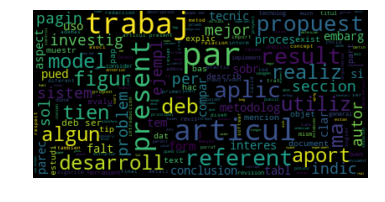

In [6]:
texts = ' '.join(X)
wordcloud = WordCloud(max_font_size=40).generate(texts)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Векторизация текстов

Воспользуемся двумя векторизаторами - первый считает кол-во вхождений слова в текст, второй - tf-idf для слова.

In [8]:
X_train_count = Count.fit_transform(X_train)
X_test_count = Count.transform(X_test)
X_train_tfidf = Tfidf.fit_transform(X_train)
X_test_tfidf = Tfidf.transform(X_test)

## Обучение модели

In [9]:
clf_count.fit(X_train_count, y_train)
clf_tfidf.fit(X_train_tfidf, y_train)

y_test_predicted_labels_count = clf_count.predict(X_test_count)

y_test_predicted_labels_tfidf = clf_tfidf.predict(X_test_tfidf)

In [10]:
for i in range(5):
    text = X_test[i]
    print(text)
    print('True label:\t{}\nPredicted label with count vectorizer:\t{}\nPredicted label with tf-idf vectorizer:\t{}\n'.format(
        y_test[i], y_test_predicted_labels_count[i], y_test_predicted_labels_tfidf[i]))

articul present diseñ implement esquem bas dat espacial articul muestr implement sobr sgbd relacional extension soport model espacial postgis especif present model entid relacion model relacional sistem gestion bas dat general articul explic clar trabaj realiz embarg muestr algun deficient redaccion ortograf algun palabr figur 2 visualiz correct comprend diseñ baj metodolog relacional si busc model bas dat espacial bas objet ademas cas postgis object orient usar diseñ orient objet ser recomend revis articul worboys object orient dat modelling for spatial datab articul muestr evalu result investig realiz much referent siti web aplic per poc referent articul cientif actual asoci tem present
True label:	0.0
Predicted label with count vectorizer:	-2.0
Predicted label with tf-idf vectorizer:	1.0

articul muestr result empir integr acopl algoritm apriori sgbd indic trabaj expuest bas trabaj agrawal shim trabaj año 1996 respect trabaj mas recient pued escog trabaj mas recient escog trabaj enf

In [11]:
print(f'Count accuracy score: {accuracy_score(y_test, y_test_predicted_labels_count)}')
print(f'Tf-idf accuracy score: {accuracy_score(y_test, y_test_predicted_labels_tfidf)}')

Count accuracy score: 0.43
Tf-idf accuracy score: 0.4
